# Treinando Modelo do Desafio de Detecção de Distração do Motorista

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil, pathlib, glob, sys

IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = os.environ.get('PWD') == '/kaggle/working'

%matplotlib inline
plt.style.use('ggplot')

In [2]:
import tensorflow as tf

tf.__version__

'2.1.0'

In [3]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
competition_name = 'state-farm-distracted-driver-detection'
root_output_local = f'{competition_name}/model' if not IN_COLAB and not IN_KAGGLE else ''
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/{competition_name}'
api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')

In [4]:
# Montando google drive caso esteja executando no google colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

## Obtendo os dados do desafio

In [5]:
from zipfile import ZipFile

def get_kaggle_json(api_location):
    api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')
    if not os.path.exists(api_local_credential_location):
        !mkdir -p ~/.kaggle
        !cp '{api_location}' '{api_local_credential_location}'

def get_kaggle_data_competition(competition_name, gdrive_kaggle_dir=None):
    if IN_COLAB and not os.path.exists(competition_name):
        gdrive_competition_path = os.path.join(gdrive_kaggle_dir, competition_name)
        if os.path.exists(gdrive_competition_path):
            print('Copiando dados do Google Drive')
            !cp -r '{gdrive_competition_path}' .

    if not os.path.exists(competition_name):
        # Instalação do pacote para acesso a API do Kaggle
        !pip -q install kaggle --upgrade
        # Download dos dados da competição
        !kaggle competitions download -c {competition_name} -p {competition_name}
        if IN_COLAB and os.path.exists(gdrive_kaggle_dir):
            !cp -r {competition_name} '{gdrive_kaggle_dir}'

def extract_files(competition_name):
    if IN_COLAB and os.path.exists(os.path.join(competition_name, f'{competition_name}.zip')):
        with ZipFile(os.path.join(competition_name, f'{competition_name}.zip'), 'r') as zipObj:
            # Extract all the contents of zip file in current directory
            zipObj.extractall(competition_name)
        os.remove(os.path.join(competition_name, f'{competition_name}.zip'))

In [6]:
# Obtem os dados somente se o notebook não esteja sendo executado no Kaggle
if not IN_KAGGLE: 
    get_kaggle_json(api_gdrive_credential_location)
    get_kaggle_data_competition(competition_name, gdrive_kaggle_dir)
    extract_files(competition_name)

In [7]:
pre_dir = '/kaggle/input' if IN_KAGGLE else ''
data_dir = os.path.join(pre_dir, competition_name, 'imgs')
test_dir = f'{data_dir}/test/'
train_dir = f'{data_dir}/train/'

## Analisando Distribuição das Imagens

In [8]:
train_data_dir = pathlib.Path(train_dir)
test_data_dir = pathlib.Path(test_dir)

train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
test_image_count = len(list(test_data_dir.glob('*.jpg')))
print(f'Train size: {train_image_count} | Test size: {test_image_count}')

Train size: 22424 | Test size: 79726


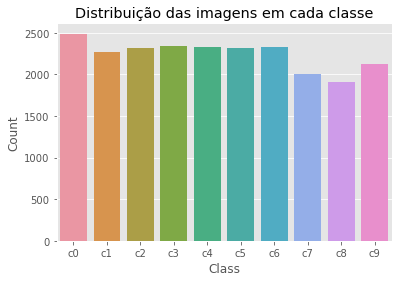

In [9]:
sns.barplot(x='Class', y='Count', data=pd.DataFrame.from_dict(
    {dir: [len(glob.glob(os.path.join(train_data_dir, dir, '*.jpg')))] for dir in os.listdir(train_data_dir)}, 
    orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Class'})).set_title('Distribuição das imagens em cada classe');

## Configurando TPU

In [10]:
# Detectando TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError: # Se Não tiver TPU disponível
    tpu = None
    
# Seleciona estratégia
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Executando na TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
    strategy = tf.distribute.get_strategy() # Estratégia padrão que funciona com GPU ou CPU
    if len(tf.config.experimental.list_physical_devices('GPU')) or len(tf.config.experimental.list_physical_devices('XLA_GPU')):
        print("GPUs Disponíveis: ", len(tf.config.experimental.list_physical_devices('GPU')) + len(tf.config.experimental.list_physical_devices('XLA_GPU')))
    else:
        print('Executando no CPU')
print("Número de Aceleradores: ", strategy.num_replicas_in_sync)

Executando no CPU
Número de Aceleradores:  1


## Configurando DataSets

In [11]:
# Obtendo nomes das classes
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
CLASS_NAMES

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype='<U2')

In [12]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [13]:
BATCH_SIZE = 256
if tpu:
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = 160
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)

In [14]:
BATCH_SIZE

256

In [15]:
train_data_gen = train_valid_generator.flow_from_directory(directory=str(train_data_dir),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 classes = list(CLASS_NAMES),
                                                 subset='training')
validation_data_gen = train_valid_generator.flow_from_directory(directory=str(train_data_dir),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 classes = list(CLASS_NAMES),
                                                 subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [16]:
validation_no_shuffe = train_valid_generator.flow_from_directory(directory=str(train_data_dir),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 classes = list(CLASS_NAMES),
                                                 subset='validation')

Found 4481 images belonging to 10 classes.


In [17]:
test_data_gen = test_generator.flow_from_directory(directory=str(data_dir), classes=['test'], class_mode=None, shuffle=False, target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 79726 images belonging to 1 classes.


## Visualizando amostra das imagens de treinamento

In [18]:
def show_batch(image_batch, label_batch=None,predict_labels=None):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        
        if predict_labels is not None:
            true_class =  CLASS_NAMES[label_batch[n]==1][0].title() if label_batch is not None else '?'
            predicted_class = CLASS_NAMES[predict_labels[n]].title()
            color = 'green' if true_class == predicted_class else 'red'
            plt.title(f'P: {predicted_class} - R: {true_class}', fontdict={'color': color if label_batch is not None else 'black'})
        elif label_batch is not None:
            plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

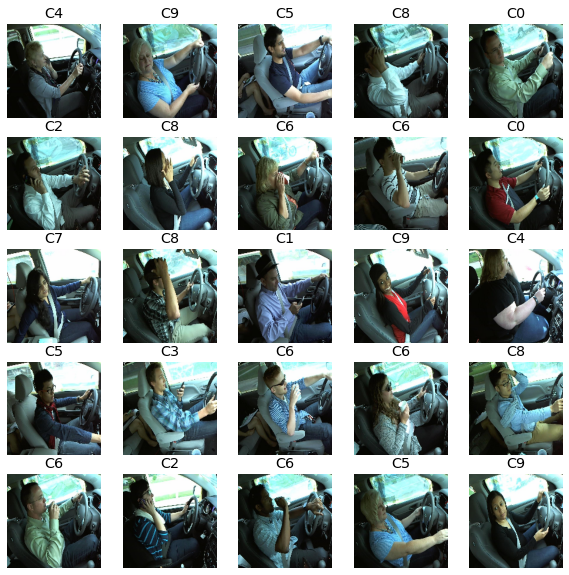

In [19]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Definindo o Modelo

In [20]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def create_model(train_base_model=False):
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = train_base_model
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.Sequential([
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ]) 
    
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      prediction_layer
    ])
    
    return model

In [21]:
def compile_model(model, learning_rate=0.001):
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [22]:
with strategy.scope():
    train_ds = train_data_gen
    valid_ds = validation_data_gen
    test_ds = test_data_gen
    if tpu:
        train_ds = tf.data.TFRecordDataset.from_generator(lambda: train_data_gen, output_types=(tf.float32, tf.float32), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, len(CLASS_NAMES)]))
        valid_ds = tf.data.TFRecordDataset.from_generator(lambda: validation_data_gen, output_types=(tf.float32, tf.float32), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, len(CLASS_NAMES)]))
        test_ds = tf.data.TFRecordDataset.from_generator(lambda: test_data_gen, output_types=(tf.float32, ), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3],))
        
    model = create_model()
    compile_model(model)

9412608/9406464 [==============================] - 1s 0us/step


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                362122    
Total params: 2,620,106
Trainable params: 362,122
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
len(model.trainable_variables)

6

## Avaliando acurácia inicial do Modelo

In [25]:
validation_steps=20
loss0,accuracy0 = model.evaluate(valid_ds, steps = validation_steps)

18/20 [==========================>...] - ETA: 3s - loss: 2.3009 - accuracy: 0.0783

## Treinando o Modelo

In [26]:
epochs = 20
history_1 = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Train for 71 steps, validate for 18 steps
Epoch 1/20
71/71 [==============================] - 151s 2s/step - loss: 2.2435 - accuracy: 0.1987 - val_loss: 2.2197 - val_accuracy: 0.2435
Epoch 2/20
71/71 [==============================] - 115s 2s/step - loss: 2.0873 - accuracy: 0.3754 - val_loss: 2.2149 - val_accuracy: 0.2374
Epoch 3/20
71/71 [==============================] - 115s 2s/step - loss: 1.9830 - accuracy: 0.4815 - val_loss: 2.2219 - val_accuracy: 0.2279
Epoch 4/20
71/71 [==============================] - 115s 2s/step - loss: 1.9277 - accuracy: 0.5344 - val_loss: 2.2491 - val_accuracy: 0.2037
Epoch 5/20
71/71 [==============================] - 114s 2s/step - loss: 1.8943 - accuracy: 0.5701 - val_loss: 2.2260 - val_accuracy: 0.2274
Epoch 6/20
71/71 [==============================] - 114s 2s/step - loss: 1.8668 - accuracy: 0.5944 - val_loss: 2.1837 - val_accuracy: 0.2665
Epoch 7/20
71/71 [==============================] - 114s 2s/step - loss: 1.8518 - accuracy: 0.6109 - val_loss: 2

In [27]:
epochs = 10
compile_model(model, learning_rate=0.0001)
history_2 = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Train for 71 steps, validate for 18 steps
Epoch 1/10
71/71 [==============================] - 122s 2s/step - loss: 1.6738 - accuracy: 0.7892 - val_loss: 2.1849 - val_accuracy: 0.2703
Epoch 2/10
71/71 [==============================] - 117s 2s/step - loss: 1.6630 - accuracy: 0.7999 - val_loss: 2.1752 - val_accuracy: 0.2798
Epoch 3/10
71/71 [==============================] - 116s 2s/step - loss: 1.6630 - accuracy: 0.7984 - val_loss: 2.1651 - val_accuracy: 0.2908
Epoch 4/10
71/71 [==============================] - 117s 2s/step - loss: 1.6627 - accuracy: 0.7999 - val_loss: 2.1690 - val_accuracy: 0.2877
Epoch 5/10
71/71 [==============================] - 120s 2s/step - loss: 1.6631 - accuracy: 0.7984 - val_loss: 2.1781 - val_accuracy: 0.2761
Epoch 6/10
71/71 [==============================] - 122s 2s/step - loss: 1.6625 - accuracy: 0.8020 - val_loss: 2.1786 - val_accuracy: 0.2743
Epoch 7/10
71/71 [==============================] - 121s 2s/step - loss: 1.6591 - accuracy: 0.8030 - val_loss: 2

In [28]:
epochs = 30

model.layers[0].trainable = True
compile_model(model, learning_rate=0.0001)
history_3 = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Train for 71 steps, validate for 18 steps
Epoch 1/30
71/71 [==============================] - 144s 2s/step - loss: 1.6195 - accuracy: 0.8404 - val_loss: 2.0038 - val_accuracy: 0.4550
Epoch 2/30
71/71 [==============================] - 135s 2s/step - loss: 1.5710 - accuracy: 0.8889 - val_loss: 1.8357 - val_accuracy: 0.6242
Epoch 3/30
71/71 [==============================] - 132s 2s/step - loss: 1.5452 - accuracy: 0.9157 - val_loss: 1.8161 - val_accuracy: 0.6409
Epoch 4/30
71/71 [==============================] - 133s 2s/step - loss: 1.5192 - accuracy: 0.9427 - val_loss: 1.7535 - val_accuracy: 0.7041
Epoch 5/30
71/71 [==============================] - 136s 2s/step - loss: 1.5051 - accuracy: 0.9574 - val_loss: 1.6701 - val_accuracy: 0.7920
Epoch 6/30
71/71 [==============================] - 131s 2s/step - loss: 1.4925 - accuracy: 0.9688 - val_loss: 1.6291 - val_accuracy: 0.8297
Epoch 7/30
71/71 [==============================] - 129s 2s/step - loss: 1.4855 - accuracy: 0.9755 - val_loss: 1

## Salvando o Modelo

In [29]:
model.save(os.path.join(root_output_local, 'model_v2.h5'))

## Carregando o Modelo

In [30]:
new_model = tf.keras.models.load_model(os.path.join(root_output_local, 'model_v2.h5')

## Avaliando o modelo treinado

In [31]:
loss1, accuracy1 = new_model.evaluate(valid_ds, steps = validation_steps)

18/20 [==========================>...] - ETA: 2s - loss: 1.4726 - accuracy: 0.9886

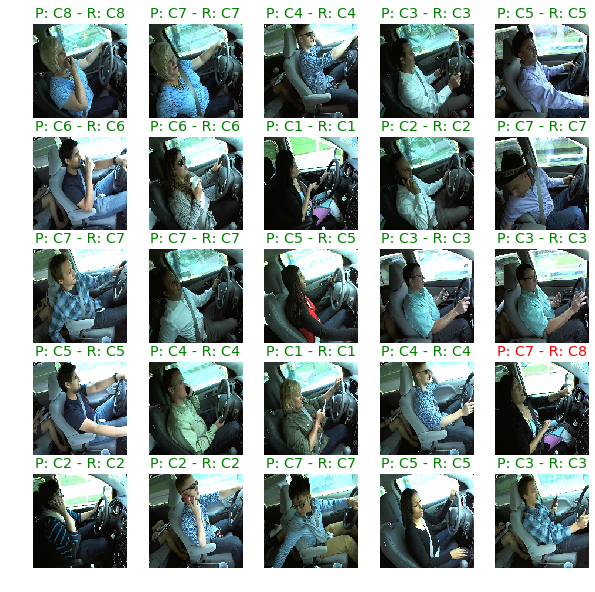

In [32]:
image_batch, label_batch = next(valid_ds)
predicted_labels = new_model.predict_classes(image_batch)
show_batch(image_batch, label_batch, predicted_labels)

### Avaliando desempenho em relação a cada classe

In [33]:
predict_classes = new_model.predict_classes(validation_no_shuffe, batch_size=None)

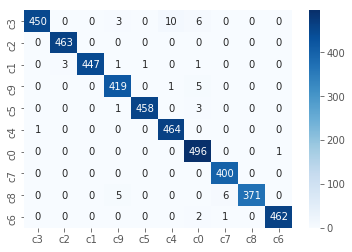

In [34]:
sns.heatmap(tf.math.confusion_matrix(validation_no_shuffe.classes, predict_classes), annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES);

### Avaliando desempenho nos dados de teste (visualmente)

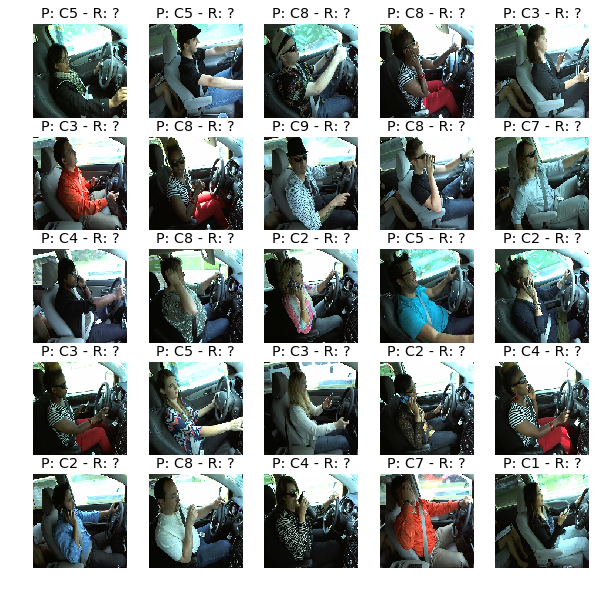

In [35]:
image_batch = next(test_ds)
predicted_labels = new_model.predict_classes(image_batch)
show_batch(image_batch, predict_labels=predicted_labels)

## Analisando a performance durante o treinamento

In [36]:
histories = [history_1, history_2, history_3]

history_df = pd.concat([pd.DataFrame(h.history) for h in histories], ignore_index=True)

### Salvando historico de treinamento

In [37]:
history_df.to_parquet(os.path.join(root_output_local, 'history.parquet')

### Carregando histórico de treinamento

In [38]:
history_df = pd.read_parquet(os.path.join(root_output_local, 'history.parquet')

history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.242889,0.198740,2.219729,0.243472
1,2.087689,0.375411,2.214924,0.237447
2,1.984455,0.481469,2.221899,0.227851
3,1.928555,0.534415,2.249079,0.203749
4,1.894150,0.570139,2.225958,0.227405


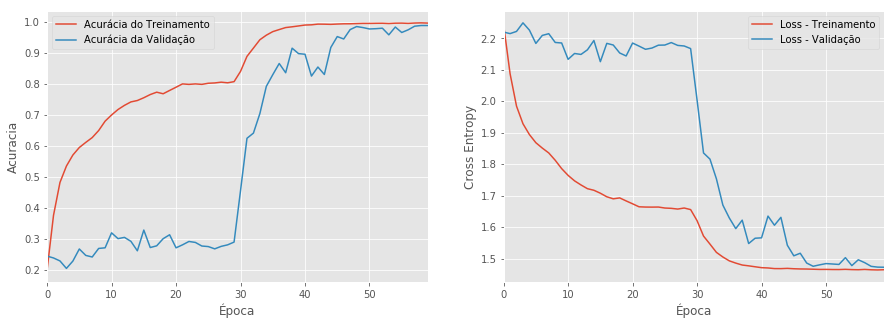

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

history_df.accuracy.plot(ax=ax1, label='Acurácia do Treinamento')
history_df.val_accuracy.plot(ax=ax1, label='Acurácia da Validação')
ax1.set_xlabel('Época')
ax1.set_ylabel('Acuracia')
ax1.legend()

history_df.loss.plot(ax=ax2, label='Loss - Treinamento')
history_df.val_loss.plot(ax=ax2, label='Loss - Validação')
ax2.set_xlabel('Época')
ax2.set_ylabel('Cross Entropy')
ax2.legend()

fig.show()